<a href="https://colab.research.google.com/github/EBUSYGIN/ML-3/blob/Kuznetsov/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import PolynomialFeatures

In [93]:
# Загрузка данных
train_path = "train.xlsx"
test_path = "test.xlsx"
train_df = pd.read_excel(train_path)
test_df = pd.read_excel(test_path)

train_df

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
...,...,...
395,2022-08-01,47500
396,2022-08-08,49000
397,2022-08-15,47500
398,2022-08-22,46500


In [ ]:
test_df

,dt,Цена на арматуру
0,2022-09-05,46000
1,2022-09-12,46000
2,2022-09-19,46000
3,2022-09-26,45500
4,2022-10-03,45500
5,2022-10-10,45000
6,2022-10-17,44000
7,2022-10-24,43000
8,2022-10-31,42000
9,2022-11-07,41500


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28 entries, 0 to 27
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                28 non-null     datetime64[ns]
 1   Цена на арматуру  28 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 580.0 bytes


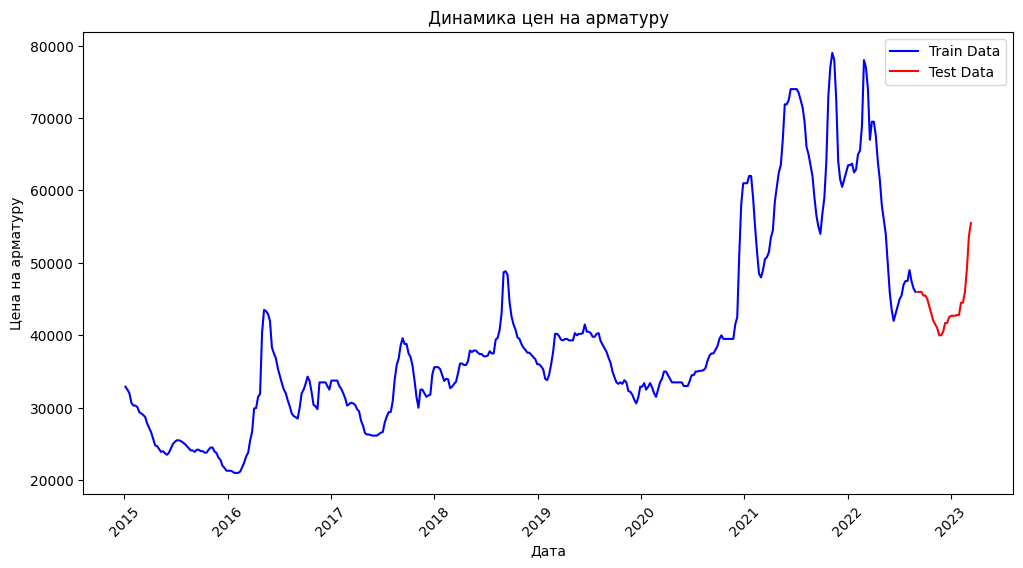

In [94]:

# Визуализация динамики цен
plt.figure(figsize=(12, 6))
plt.plot(train_df["dt"], train_df["Цена на арматуру"], label="Train Data", color='blue')
plt.plot(test_df["dt"], test_df["Цена на арматуру"], label="Test Data", color='red')
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Динамика цен на арматуру")
plt.legend()
plt.xticks(rotation=45)
plt.show()


In [95]:

print(train_df['Цена на арматуру'].describe())

count      400.000000
mean     39229.475000
std      13407.979668
min      21000.000000
25%      31075.000000
50%      35450.000000
75%      42000.000000
max      79000.000000
Name: Цена на арматуру, dtype: float64


In [96]:
# Преобразование даты в индекс
train_df["dt"] = pd.to_datetime(train_df["dt"])
test_df["dt"] = pd.to_datetime(test_df["dt"])
train_df.set_index("dt", inplace=True)
test_df.set_index("dt", inplace=True)

In [97]:
# Разложение временного ряда
decomposition = seasonal_decompose(train_df["Цена на арматуру"], model='additive', period=52)

Text(0, 0.5, 'Цена на арматуру')

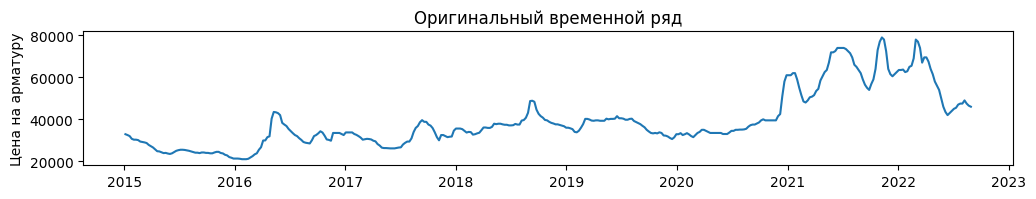

In [98]:
plt.figure(figsize=(12, 8))

# Оригинальный ряд
plt.subplot(4, 1, 1)
plt.plot(decomposition.observed)
plt.title('Оригинальный временной ряд')
plt.ylabel('Цена на арматуру')

Text(0, 0.5, 'Тренд')

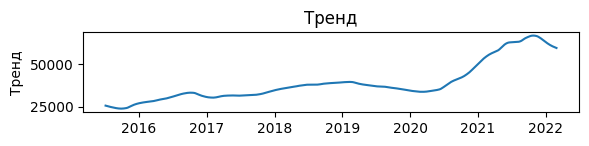

In [99]:
plt.subplot(4, 1, 2)
plt.plot(decomposition.trend)
plt.title('Тренд')
plt.ylabel('Тренд')

Можно заметить, что цена на арматуру имеет выраженный восходящий тренд, особенно начиная с 2020 года. В период с 2015 по 2019 год тренд был более стабильным, с небольшими колебаниями, но с 2020 года наблюдается резкий рост цен, который продолжается до 2022 года.

Text(0, 0.5, 'Сезонность')

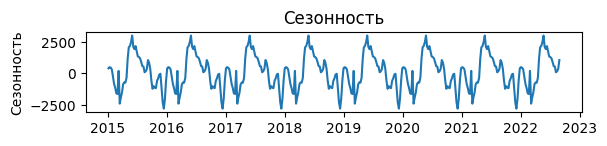

In [100]:
plt.subplot(4, 1, 3)
plt.plot(decomposition.seasonal)
plt.title('Сезонность')
plt.ylabel('Сезонность')

На графике сезонности можно заметить, что цена на арматуру имеет определенные повторяющиеся паттерны в течение года. Например, возможны сезонные колебания, связанные с сезонным спросом на строительные материалы (например, рост цен в весенне-летний период и снижение в осенне-зимний).

Text(0, 0.5, 'Остатки')

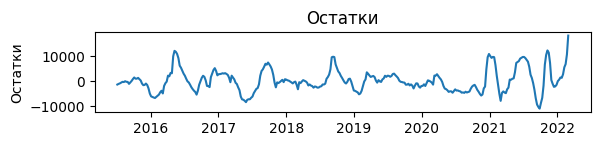

In [91]:
plt.subplot(4, 1, 4)
plt.plot(decomposition.resid)
plt.title('Остатки')
plt.ylabel('Остатки')

На графике остатков можно увидеть, что они относительно равномерно распределены вокруг нуля, что указывает на то, что модель декомпозиции хорошо уловила тренд и сезонность.

In [101]:
# Проверка стационарности
adf_test = adfuller(train_df["Цена на арматуру"])
print(f"ADF Statistic: {adf_test[0]}, p-value: {adf_test[1]}")

ADF Statistic: -1.9258699893713456, p-value: 0.31999061025699155


In [102]:

# Добавление новых признаков
train_df['year'] = train_df.index.year
train_df['month'] = train_df.index.month
test_df['year'] = test_df.index.year
test_df['month'] = test_df.index.month


In [103]:
# Скользящее среднее
train_df['rolling_mean_3'] = train_df['Цена на арматуру'].rolling(window=3).mean().fillna(method='bfill')
test_df['rolling_mean_3'] = test_df['Цена на арматуру'].rolling(window=3).mean().fillna(method='bfill')

# Лаги (задержки)
train_df['lag_1'] = train_df['Цена на арматуру'].shift(1).fillna(method='bfill')
test_df['lag_1'] = test_df['Цена на арматуру'].shift(1).fillna(method='bfill')

# Преобразование даты в числовой формат
train_df["timestamp"] = train_df.index.astype(np.int64) // 10**9
test_df["timestamp"] = test_df.index.astype(np.int64) // 10**9

<ipython-input-103-20168b1ee927>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df['rolling_mean_3'] = train_df['Цена на арматуру'].rolling(window=3).mean().fillna(method='bfill')
<ipython-input-103-20168b1ee927>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df['rolling_mean_3'] = test_df['Цена на арматуру'].rolling(window=3).mean().fillna(method='bfill')
<ipython-input-103-20168b1ee927>:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train_df['lag_1'] = train_df['Цена на арматуру'].shift(1).fillna(method='bfill')
<ipython-input-103-20168b1ee927>:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test_df['lag_1'] = test_d

In [112]:
# Создание полиномиальных признаков
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(train_df[["timestamp", "year", "month", "rolling_mean_3", "lag_1"]])
X_test_poly = poly.transform(test_df[["timestamp", "year", "month", "rolling_mean_3", "lag_1"]])

# Разделение на признаки и целевую переменную
y_train = train_df["Цена на арматуру"]
y_test = test_df["Цена на арматуру"]


In [113]:

# Обучение модели
model = LinearRegression()
model.fit(X_train_poly, y_train)


LinearRegression()

In [114]:
# Прогнозирование
predictions = model.predict(X_test_poly)

MAE: 895.7040900504154, MSE: 1799453.9923757426, RMSE: 1341.4372860390242, MAPE: 1.910931263539125, SMAPE: 1.9456742081708722


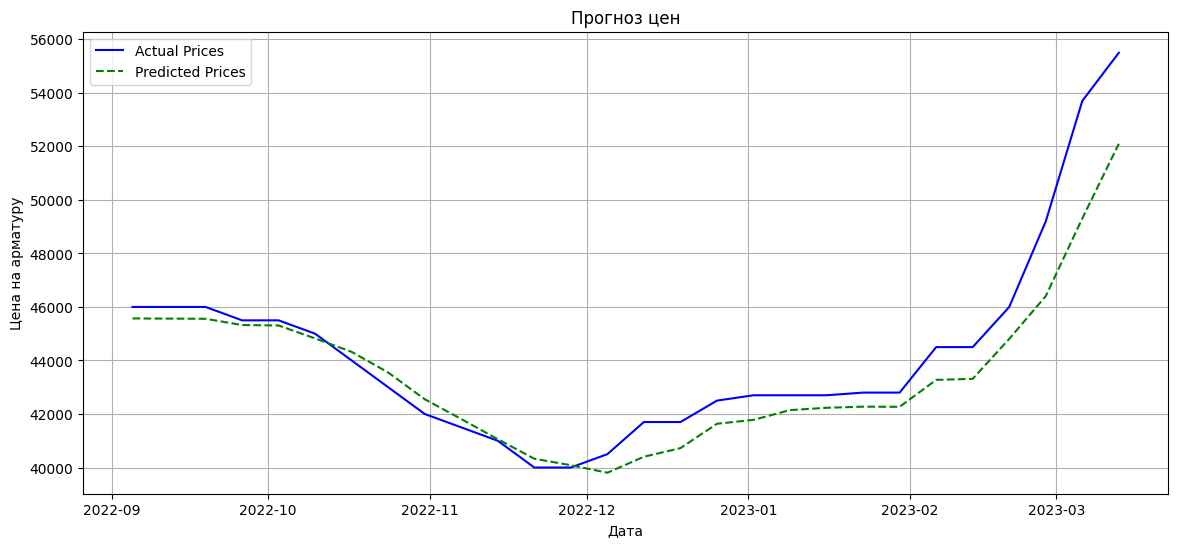

In [107]:
# Оценка модели
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
smape = 100 * np.mean(2 * np.abs(predictions - y_test) / (np.abs(predictions) + np.abs(y_test)))

print(f"MAE: {mae}, MSE: {mse}, RMSE: {rmse}, MAPE: {mape}, SMAPE: {smape}")

# Визуализация прогнозов
plt.figure(figsize=(14, 6))
plt.plot(test_df.index, y_test, label="Actual Prices", color='blue')
plt.plot(test_df.index, predictions, label="Predicted Prices", color='green', linestyle='dashed')
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Прогноз цен")
plt.legend()
plt.grid()
plt.show()